In this notebook will rebuild Thomas Schelling's model of housing segregation. The original paper can be found [here](https://www.uzh.ch/cmsssl/suz/dam/jcr:00000000-68cb-72db-ffff-ffffff8071db/04.02_schelling_71.pdf).

In [1]:
import re
import time
import random
import networkx as nx
import matplotlib.pyplot as plt

## 1. BUILD THE NEIGHBORHOOD
We will use a network structure to keep track of the pattern of spots in the neighborhood 'neighbor' relations.

In [3]:
def latticify(gridwidth, gridlength, diagonals = True):
    lots = gridwidth * gridlength
    Neighborhood = nx.Graph()
    xcoord ={}
    ycoord ={}
    residents = {}
    for x in range(0,lots):
        Neighborhood.add_node(x)
        ycoord[x] = int(x/gridlength)
        xcoord[x] = x%gridlength
        residents[x] = None
    nx.set_node_attributes(Neighborhood,'xcoord',xcoord)
    nx.set_node_attributes(Neighborhood,'ycoord',ycoord)
    nx.set_node_attributes(Neighborhood,'residents',residents)
    #print xcoord
    ##This double loop will add edges between any two neighbors in the neighboorhood
    #print Neighborhood[6]
    for a in range(0,lots):
        for b in range(0,lots):
            if a > b:
                h_dist = abs(Neighborhood.node[a]['xcoord'] - Neighborhood.node[b]['xcoord'])
                v_dist = abs(Neighborhood.node[a]['ycoord'] - Neighborhood.node[b]['ycoord'])
                if h_dist + v_dist == 1:
                    Neighborhood.add_edge(a,b)
                elif (h_dist == 1) & (v_dist ==1):
                    if diagonals ==True:
                        Neighborhood.add_edge(a,b)
                    else:
                        pass
                else:
                    pass
    return Neighborhood

We can call the function here to check the neighborhood:

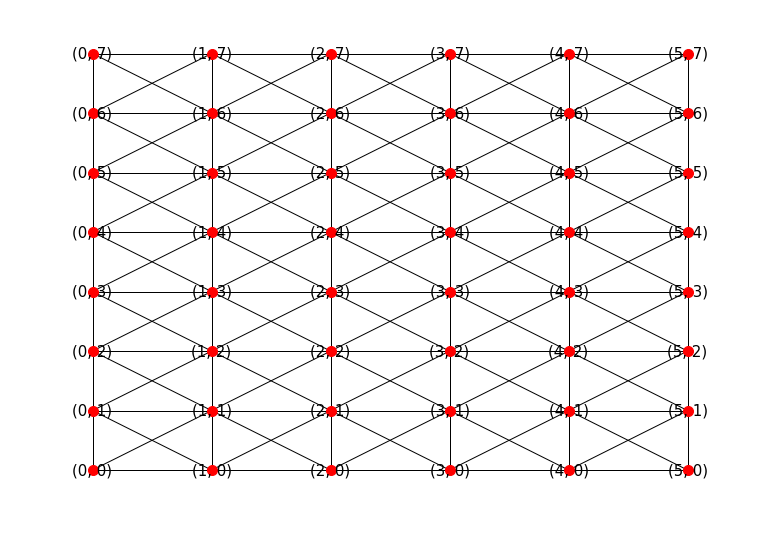

In [18]:
N = latticify(8,6,diagonals = True)
label_value_dict = {}
pos = {}
plt.figure(figsize=(10,7))
for q in nx.nodes(N):
    label_value_dict[q]= (N.node[q]['xcoord'],N.node[q]['ycoord'])
    pos[q]=[q%6/float(8),int(q/6)/float(8)]
nx.draw(N,pos,font_size = 15,labels = label_value_dict,node_size = 100)

plt.show()

## 2. BUILD THE NEIGHBORS, RANDOMLY GIVE THEM A SPOT IN THE NEIGHBORHOOD

In [7]:
class neighbor:
    def __init__(self,neighbor_id,color,in_group,out_group,home):
        self.id = neighbor_id
        self.color = color
        self.in_group = in_group
        self.out_group = out_group
        self.home = home
    def move(self,new_location):
        self.home = new_location

In [8]:
Neighbors = []
for x in range(0,12):
    NewHome = None
    while NewHome == None:
        PotentialHome = random.randint(0,47)
        if N.node[PotentialHome]['residents']==None:
            N.node[PotentialHome]['residents']=x
            NewHome = PotentialHome
        else:
            pass
    Neighbors.append(neighbor(x,'blue',0.4,0.0,NewHome))
for y in range(12,24):
    NewHome = None
    while NewHome == None:
        PotentialHome = random.randint(0,47)
        if N.node[PotentialHome]['residents']==None:
            N.node[PotentialHome]['residents']=y
            NewHome = PotentialHome
        else:
            pass
    Neighbors.append(neighbor(y,'green',0.4,0.0,NewHome))

#N = latticify(8,6,diagonals = False)
color_value_dict = {}
for q in nx.nodes(N):
    resident = N.node[q]['residents']
    #print resident
    try:
        if Neighbors[int(resident)].color == 'blue':
            color_value_dict[q]= 'blue'
        elif Neighbors[int(resident)].color == 'green':
            color_value_dict[q] ='green'
        else:
            color_value_dict[q] = 'white'
    except:
        color_value_dict[q] = 'white'
#print color_value_dict

## CHECK THE POPULATED NEIGHBORHOOD

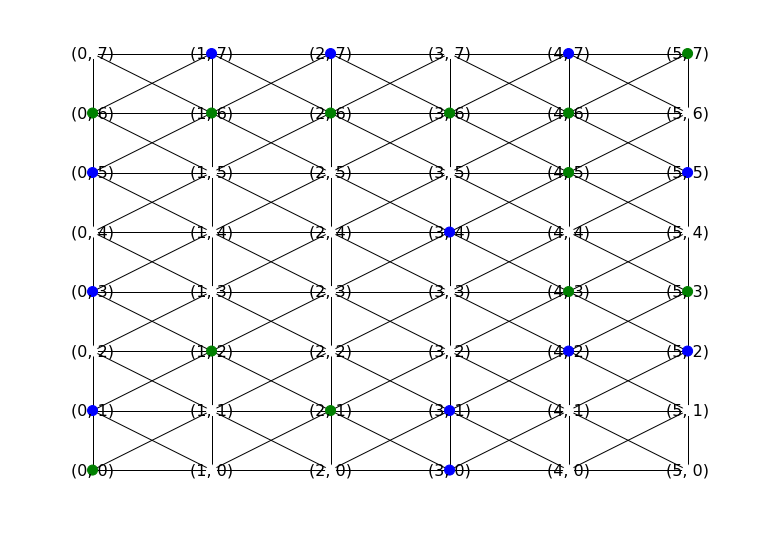

In [16]:
plt.figure(figsize=(10,7))
color_value = [color_value_dict.get(node) for node in N.nodes()]
nx.draw(N,pos,font_size = 16,labels = label_value_dict,node_size = 100,node_color = color_value)
plt.show()

## 3. BUILD FUNCTION THAT MEASURES SEGREGATION

TODO: Can we get the equation Schelling uses? If we have it in latex form we can easily present it here.

In [21]:
def measure_segregation(network, residents):
    mixed_tie = 0
    blue_tie = 0
    green_tie = 0
    possibleedges = network.edges()
    for x in possibleedges:
        res1 = network.node[x[0]]['residents']
        res2 = network.node[x[1]]['residents']
        if (res1 != None) & (res2 != None):
            if (residents[res1].color == 'blue') & (residents[res2].color =='blue'):
                blue_tie = blue_tie + 1
            elif (residents[res1].color == 'green') & (residents[res2].color =='green'):
                green_tie = green_tie + 1
            else:
                mixed_tie = mixed_tie + 1
    return mixed_tie,blue_tie,green_tie

In [20]:
print measure_segregation(N,Neighbors)

(0, 0, 0)


## 4. BUILD LOOP THAT MOVES THE NEIGHBORS AROUND

## First build functions that check desirability of locations for neighbors

In [24]:
def checkoldspot(neighbor,allneighbors,theneighborhood):
    neighbor_outgroup_pref = neighbor.out_group
    neighbor_ingroup_pref = neighbor.in_group
    in_group_neighbors = 0
    out_group_neighbors = 0
    neighbor_lots = theneighborhood.neighbors(neighbor.id)
    the_neighbors = []
    for t in neighbor_lots:
        a_neighbor = theneighborhood.node[t]['residents']
        if a_neighbor != None:
            the_neighbors.append(a_neighbor)
    #print the_neighbors
    for u in the_neighbors:
        if allneighbors[u].color == neighbor.color:
            in_group_neighbors = in_group_neighbors + 1
        else:
            out_group_neighbors = out_group_neighbors + 1
    if (in_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_ingroup_pref:
        if (out_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_outgroup_pref:
            good_spot = True
        else:
            good_spot = False
    else:
        good_spot = False
    return good_spot

def checknewspot(neighbor,newspot,allneighbors,theneighborhood):
    if theneighborhood.node[newspot]['residents'] == None:
        neighbor_outgroup_pref = neighbor.out_group
        neighbor_ingroup_pref = neighbor.in_group
        in_group_neighbors = 0
        out_group_neighbors = 0
        current_in_group_neighbors = 0
        current_out_group_neighbors = 0
        neighbor_lots = theneighborhood.neighbors(newspot)
        the_neighbors = []
        for t in neighbor_lots:
            a_neighbor = theneighborhood.node[t]['residents']
            if a_neighbor != None:
                the_neighbors.append(a_neighbor)
        #print the_neighbors
        for u in the_neighbors:
            if allneighbors[u].color == neighbor.color:
                in_group_neighbors = in_group_neighbors + 1
            else:
                out_group_neighbors = out_group_neighbors + 1
        #Get old spots for comparison
        currentneighbor_lots = theneighborhood.neighbors(neighbor.id)
        current_neighbors = []
        for s in currentneighbor_lots:
            a_cur_neighbor = theneighborhood.node[s]['residents']
            if a_cur_neighbor != None:
                current_neighbors.append(a_cur_neighbor)
        #print the_neighbors
        for r in current_neighbors:
            if allneighbors[r].color == neighbor.color:
                current_in_group_neighbors = current_in_group_neighbors + 1
            else:
                current_out_group_neighbors = current_out_group_neighbors + 1
        if ((in_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_ingroup_pref) & ((out_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) >= neighbor_outgroup_pref):
            good_spot = True
        else:
            ing_improve = (in_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) > min((current_in_group_neighbors/float(current_in_group_neighbors+current_out_group_neighbors+.001),neighbor_ingroup_pref))
            og_improve = (out_group_neighbors/float(in_group_neighbors+out_group_neighbors+.001)) > min((current_out_group_neighbors/float(current_in_group_neighbors+current_out_group_neighbors+.001),neighbor_ingroup_pref))
            good_spot = ing_improve and og_improve
    else:
        good_spot = False
    return good_spot

TODO: What is this next step doing?

In [25]:
Num_Of_Moves = 10000
Actual_Moves = 0
for t in range(0,Num_Of_Moves):
    Mover = Neighbors[random.randint(0,23)]
    if checkoldspot(Mover,Neighbors,N) == False:
        NewDigs = random.randint(0,47)
        if checknewspot(Mover,NewDigs,Neighbors,N) == True:
            OldDigs = Mover.home
            N.node[OldDigs]['residents'] = None
            N.node[NewDigs]['residents'] = Mover.id
            Mover.move(NewDigs)
            Actual_Moves = Actual_Moves + 1
        else:
            pass
    else:
        pass
print Actual_Moves

color_value_dict = {}

for q in nx.nodes(N):
    resident = N.node[q]['residents']
    #print resident
    try:
        if Neighbors[int(resident)].color == 'blue':
            color_value_dict[q]= 'blue'
        elif Neighbors[int(resident)].color == 'green':
            color_value_dict[q] ='green'
        else:
            color_value_dict[q] = 'white'
    except:
        color_value_dict[q] = 'white'

0


## CHECK THE SHIFTED NEIGHBORHOOD

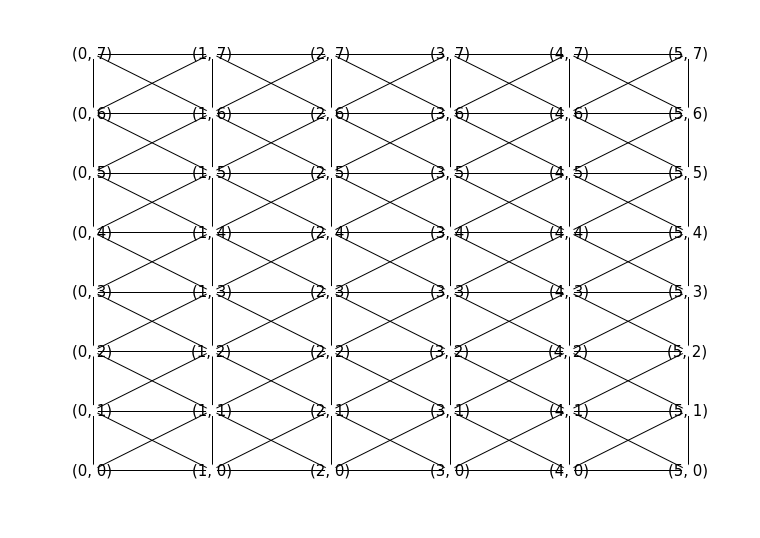

(0, 0, 0)

In [30]:
#TODO: Is this correct? All notes are white.
color_value = [color_value_dict.get(node) for node in N.nodes()]
plt.figure(figsize=(10,7))
nx.draw(N,pos,font_size = 15,labels = label_value_dict,node_size = 100,node_color = color_value)
plt.show()

measure_segregation(N,Neighbors)

## 5. BUILD FUNCTION THAT DOES ALL OF THIS SO YOU CAN ITERATE THROUGH A PARAMETER SPACE

In [31]:
def schellify(Rows,Columns,BlueResidents,BlueIGP,BlueOGP,GreenResidents,GreenIGP,GreenOGP,Moves,Diagonal = True,ShowPlot = False):
    #Build a Neighborhood
    TheNeighborhood = latticify(Columns, Rows, diagonals = Diagonal)
    #Fill it with Neighbors
    TheNeighbors = []
    for x in range(0,BlueResidents):
        NewHome = None
        while NewHome == None:
            PotentialHome = random.randint(0,Rows*Columns-1)
            if TheNeighborhood.node[PotentialHome]['residents']==None:
                TheNeighborhood.node[PotentialHome]['residents']=x
                NewHome = PotentialHome
            else:
                pass
        TheNeighbors.append(neighbor(x,'blue',BlueIGP,BlueOGP,NewHome))
    for y in range(BlueResidents,BlueResidents+GreenResidents):
        NewHome = None
        while NewHome == None:
            PotentialHome = random.randint(0,Rows*Columns-1)
            if TheNeighborhood.node[PotentialHome]['residents']==None:
                TheNeighborhood.node[PotentialHome]['residents']=y
                NewHome = PotentialHome
            else:
                pass
        TheNeighbors.append(neighbor(y,'green',GreenIGP,GreenOGP,NewHome))
    d,e,f = measure_segregation(TheNeighborhood, TheNeighbors)
    #Let the Neighbors Move Around
    Actual_Moves = 0
    for m in range(0,Moves):
        Mover = TheNeighbors[random.randint(0,BlueResidents+GreenResidents-1)]
        if checkoldspot(Mover,TheNeighbors,TheNeighborhood) == False:
            NewDigs = random.randint(0,Rows*Columns-1)
            if checknewspot(Mover,NewDigs,TheNeighbors,TheNeighborhood) == True:
                OldDigs = Mover.home
                TheNeighborhood.node[OldDigs]['residents'] = None
                TheNeighborhood.node[NewDigs]['residents'] = Mover.id
                Mover.move(NewDigs)
                Actual_Moves = Actual_Moves + 1
            else:
                pass
        else:
            pass
    #Measure Segregation of the Shuffled Neighborhood and Return Results
    if ShowPlot == True:
        label_value_dict = {}
        pos = {}
        for q in nx.nodes(TheNeighborhood):
            label_value_dict[q]= q
            pos[q]=[int(q/Rows)/float(Rows),q%Columns/float(Columns)]
        color_value_dict = {}
        for q in nx.nodes(TheNeighborhood):
            resident = TheNeighborhood.node[q]['residents']
            #print resident
            try:
                if TheNeighbors[int(resident)].color == 'blue':
                    color_value_dict[q]= 'blue'
                elif TheNeighbors[int(resident)].color == 'green':
                    color_value_dict[q] ='green'
                else:
                    color_value_dict[q] = 'white'
            except:
                color_value_dict[q] = 'white'
        color_value = [color_value_dict.get(node) for node in TheNeighborhood.nodes()]

        nx.draw(TheNeighborhood,pos,font_size = 5,labels = label_value_dict,node_size = 100,node_color = color_value)
        plt.show()
    else:
        pass
    a,b,c = measure_segregation(TheNeighborhood, TheNeighbors)
    return d,e,f,Actual_Moves,a,b,c

## 6. USE FUNCTION TO LOOP THROUGH PARAMETER SPACE

In [ ]:
for x in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    for y in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
        for z in range(0,10):
            a,b,c,d,e,f,g = schellify(8,8,25,x,y,25,x,y,10000)
            print str(x) + '|' + str(y) + '|' +str(z) +'|' + str(round(e/float(e+f+g),3))

0|0|0|0.465
0|0|1|0.504
0|0|2|0.477
0|0|3|0.512
0|0|4|0.548
0|0|5|0.551
0|0|6|0.419
0|0|7|0.492
0|0|8|0.476
0|0|9|0.548
0|0.1|0|0.488
0|0.1|1|0.535
0|0.1|2|0.52
0|0.1|3|0.544
0|0.1|4|0.547
0|0.1|5|0.536
0|0.1|6|0.437
0|0.1|7|0.467
0|0.1|8|0.584
0|0.1|9|0.465
0|0.2|0|0.527
0|0.2|1|0.559
0|0.2|2|0.529
0|0.2|3|0.488
0|0.2|4|0.543
0|0.2|5|0.568
0|0.2|6|0.562
0|0.2|7|0.525
0|0.2|8|0.602
0|0.2|9|0.532
0|0.3|0|0.488
0|0.3|1|0.449
0|0.3|2|0.508
0|0.3|3|0.534
0|0.3|4|0.568
0|0.3|5|0.574
0|0.3|6|0.484
0|0.3|7|0.544
0|0.3|8|0.52
0|0.3|9|0.5
0|0.4|0|0.587
0|0.4|1|0.437
0|0.4|2|0.523
0|0.4|3|0.467
0|0.4|4|0.585
0|0.4|5|0.496
0|0.4|6|0.531
0|0.4|7|0.427
0|0.4|8|0.443
0|0.4|9|0.567
0|0.5|0|0.54
0|0.5|1|0.557
0|0.5|2|0.511
0|0.5|3|0.525
0|0.5|4|0.555
0|0.5|5|0.541
0|0.5|6|0.529
0|0.5|7|0.532
0|0.5|8|0.5
0|0.5|9|0.481
0|0.6|0|0.504
0|0.6|1|0.568
0|0.6|2|0.532
0|0.6|3|0.567
0|0.6|4|0.484
0|0.6|5|0.43
0|0.6|6|0.511
0|0.6|7|0.569
0|0.6|8|0.553
0|0.6|9|0.484
0|0.7|0|0.581
0|0.7|1|0.522
0|0.7|2|0.575
0|0.7|